# Demo: Serenity Derivatives API - Option Pricing

Serenity builds in sophisticated option and rates analytics as part of its core offering, and these functions
are all exposed via the API. This notebook shows how you can use it to price European options on BTC and ETH.

In [1]:
%%capture --no-stderr --no-display
%load_ext autoreload
%autoreload 2

In [2]:
from os import getenv
from serenity_sdk.widgets import ConnectWidget

# if you want to auto-connect, set this environment variable to your desired default
connect_widget = ConnectWidget(getenv('SERENITY_CONFIG_ID', None))

In [3]:
from datetime import datetime, timedelta
from typing import List, Dict
from uuid import UUID, uuid4

from time import sleep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

from serenity_types.pricing.derivatives.rates.yield_curve import YieldCurveVersion
from serenity_types.pricing.derivatives.options.valuation import (
    DiscountingMethod, 
    MarketDataOverride, 
    YieldCurveOverride,
    OptionValuationRequest, 
    OptionValuation)
from serenity_types.pricing.derivatives.options.volsurface import (
    InterpolatedVolatilitySurface, VolModel, DiscountingMethod, ProjectionMethod
)

from serenity_sdk.renderers.derivatives.request_helpers import (
    run_compute_option_valuations, 
    run_multiple_option_valuation_requests
)
from serenity_sdk.renderers.derivatives.widget_tools import OptionChooser
from serenity_sdk.renderers.derivatives.table_plot import (
    YieldCurveTablePlot, 
    VolatilitySurfaceTablePlot, 
    OptionValuationResultTablePlot, 
    plot_valuation_results,
    plot_bumped_pv
)
from serenity_sdk.renderers.derivatives.overrides import apply_option_valuation_overrides
from serenity_sdk.renderers.derivatives.converters import convert_object_dict_to_df, convert_object_list_to_df

# set default plot parameters
plt.rcParams['font.size'] = '16'

# create an alias to the api
api = connect_widget.get_api()

# Load samples of pre-defined option instruments

### Load & peek at samples of predefined options

OptionChooser is a helper function. It wraps 

* `api.pricer().get_supported_underliers()`: get the supported underlier information (i.e. BTC and ETH)
* `api.pricer().get_supported_options()`: get a list of pre-defined options from Deribit. 

In [4]:
option_chooser = OptionChooser(api)
option_chooser.data.head(3)

,asset_id,asset_type,native_symbol,underlier_asset_id,contract_size,option_type,option_style,strike_price,expiry,expiry_datetime,native_symbol_underlier,option_type_str
0,b5a1c1e7-8043-5148-9270-6503b9042116,AssetType.LISTED_OPTION,BTC-28DEC22-14000-C,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,1.0,OptionType.CALL,OptionStyle.EUROPEAN,14000.0,"expiration_date=datetime.date(2022, 12, 28) ex...",2022-12-28 08:00:00,BTC,CALL
1,007e64e4-07d9-5095-931f-f006012d4607,AssetType.LISTED_OPTION,BTC-28DEC22-14000-P,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,1.0,OptionType.PUT,OptionStyle.EUROPEAN,14000.0,"expiration_date=datetime.date(2022, 12, 28) ex...",2022-12-28 08:00:00,BTC,PUT
2,01c08c8c-ebc7-592a-a203-fa9198c70205,AssetType.LISTED_OPTION,BTC-28DEC22-14500-C,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,1.0,OptionType.CALL,OptionStyle.EUROPEAN,14500.0,"expiration_date=datetime.date(2022, 12, 28) ex...",2022-12-28 08:00:00,BTC,CALL


## Select the option to use as a base line

In [5]:
print('Select an option to play with')
display(option_chooser.get_widget_to_display())

Select an option to play with


In [6]:
# Show the details of the option selected
the_default_option_info = option_chooser.get_selected_option()
pd.Series(the_default_option_info)

asset_id                                41cd5606-2a55-50f8-bccd-a41637eebb68
asset_type                                           AssetType.LISTED_OPTION
native_symbol                                            BTC-29SEP23-20000-C
underlier_asset_id                      78e2e8e2-419d-4515-9b6a-3d5ff1448e89
contract_size                                                            1.0
option_type                                                  OptionType.CALL
option_style                                            OptionStyle.EUROPEAN
strike_price                                                         20000.0
expiry                     expiration_date=datetime.date(2023, 9, 29) exp...
expiry_datetime                                          2023-09-29 08:00:00
native_symbol_underlier                                                  BTC
dtype: object

# Option Valuation

Helper functions: Throughout this notebook, we use the following two helper functions that wraps `api.pricer().compute_option_valuations` to help displaying valuation results. 
* `run_compute_option_valuations`
* `run_multiple_option_valuation_requests`

For example, API's `compute_option_valuations` take an array of option valuations. Each option valuation is identified using a unique uuid. To help visualising option valuation results, `run_compute_option_valuations` wraps `compute_option_valuations` and takes a dictionary of option valuations with keys set by users. The valuation results are unpacked and put into a Pandas dataframe with columns corresponding to the keys. 

## Define demo option valuations

* Use the asset_id (uuid) of the pre-defined option to construct a option valuation object
* Also, create its replica using option attributues


In [7]:
# The default option valuation object
the_default_optval = OptionValuation(
    option_valuation_id=str(uuid4()),
    qty = 10, 
    option_asset_id=the_default_option_info['asset_id'])

# Replicate the same option using the attributes of the prefeined option earlier
the_replica_optval = OptionValuation(
    option_valuation_id=str(uuid4()),
    qty = the_default_optval.qty,  # use the qty from the default option
    underlier_asset_id=the_default_option_info['underlier_asset_id'],
    strike=the_default_option_info['strike_price'],
    expiry=the_default_option_info['expiry_datetime'],
    option_type=the_default_option_info['option_type'],
    option_style=the_default_option_info['option_style'],
    contract_size=the_default_option_info['contract_size']
    )

In [8]:
# use the predefined option (default option)
demo0_optvals = {'predefined': the_default_optval}
convert_object_dict_to_df(demo0_optvals)

,predefined
contract_size,1
expiry,None
implied_vol_override,None
option_asset_id,41cd5606-2a55-50f8-bccd-a41637eebb68
option_style,OptionStyle.EUROPEAN
option_type,None
option_valuation_id,f0a0582d-b9cf-4080-a529-74d564f03a23
qty,10
spot_price_override,None
strike,None


## Real-time and Historical valuation modes

1. Real-time valuation model: With `as_of_time` left empty. 
1. Historical valuation mode: With `as_of_time` specified. 

### Real-time Valuation Model: Leave `as_of_time`` as empty.

In [9]:
# Run several times, sleep a few seconds after each run. 
a_res = {}
num_calls, sleep_sec= 5, 1
print(f"Start making {num_calls} calls, {sleep_sec} seconds apart. Please, wait at least {num_calls * sleep_sec} seconds.")
for j in range(num_calls):
    now_ts = datetime.utcnow()
    res_table = run_compute_option_valuations(api, demo0_optvals)
    a_res[now_ts] = res_table.iloc[:,0]
    if j < num_calls-1:
        sleep(sleep_sec)

print('Expected Behaviour: Results should change over time.')
res_df = pd.DataFrame(a_res)
res_df

Start making 5 calls, 1 seconds apart. Please, wait at least 5 seconds.
Expected Behaviour: Results should change over time.


,2022-12-27 23:21:31.673302,2022-12-27 23:21:33.284958,2022-12-27 23:21:34.885630,2022-12-27 23:21:36.462572,2022-12-27 23:21:38.141033
option_valuation_id,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23
vol_model,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI
pv,25057.867076,25057.867076,25057.867076,25057.491134,25057.491134
iv,0.632399,0.632399,0.632399,0.632399,0.632399
spot_notional,167012.577647,167012.577647,167012.577647,167010.071965,167010.071965
spot_price,16701.257765,16701.257765,16701.257765,16701.007197,16701.007197
forward_price,16616.82525,16616.82525,16616.82525,16616.82525,16616.82525
projection_rate,-0.006722,-0.006722,-0.006722,-0.006702,-0.006702
discounting_rate,-0.010285,-0.010285,-0.010285,-0.010265,-0.010265
delta,0.486149,0.486149,0.486149,0.486149,0.486149


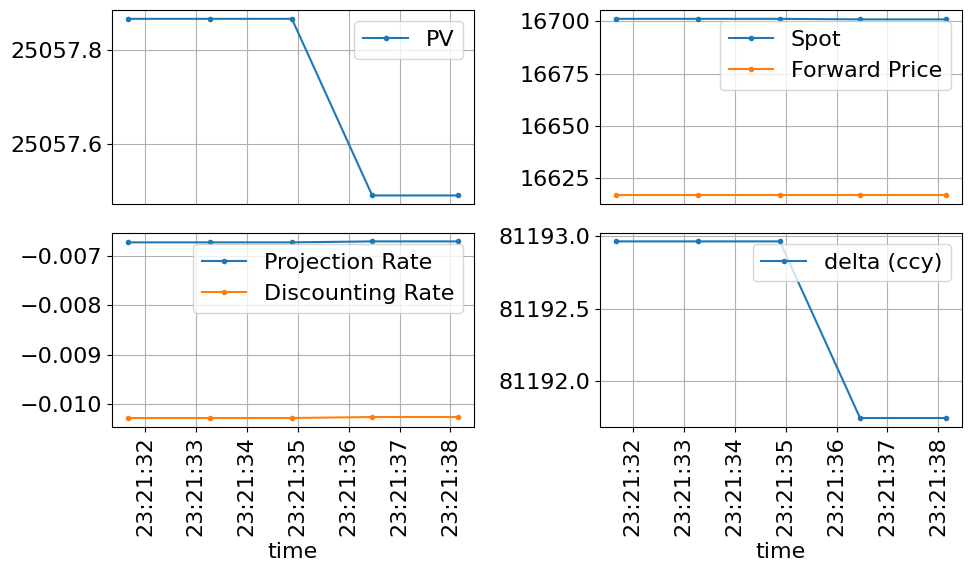

In [10]:
# Let's plot some key values
plot_valuation_results(res_df)

### Historical Valuation Mode: Specify `as_of_time`

In [11]:
# Run several times, separated by a few second
# We should get the same results. 

as_of_time = datetime.utcnow()
a_res = {}
num_calls, sleep_sec = 2, 2.5
for j in range(num_calls):
    res_table = run_compute_option_valuations(api, demo0_optvals, as_of_time=as_of_time)
    a_res[f"run_{j}"] = res_table.iloc[:,0]
    if j < num_calls-1:
        print(f'sleeping {sleep_sec} seconds.'), sleep(sleep_sec)

print('Expected Behaviour: They should return the exactly the same results since "as_of_time" is specified.')

pd.DataFrame(a_res)

sleeping 2.5 seconds.
Expected Behaviour: They should return the exactly the same results since "as_of_time" is specified.


,run_0,run_1
option_valuation_id,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23
vol_model,VolModel.SVI,VolModel.SVI
pv,24801.840882,24801.840882
iv,0.632399,0.632399
spot_notional,166795.1,166795.1
spot_price,16679.51,16679.51
forward_price,16569.199931,16569.199931
projection_rate,-0.008801,-0.008801
discounting_rate,-0.008757,-0.008757
delta,0.482745,0.482745


## Different Valuation Modes
In addition to real-time and historical modes, we allow other modes by specifying `projection_method` and `discounting_method`. 

At this point, some of the supported combinations are demonstrated below. 

In [12]:
my_options = [the_default_optval]
as_of_time = datetime.utcnow()

val_requests = {
    'real-time (default)': OptionValuationRequest(options=my_options), 
    'historical (default)' : OptionValuationRequest(options=my_options, as_of_time=as_of_time),
    'real-time (PM=F/DM=S)': OptionValuationRequest(options=my_options, projection_method=ProjectionMethod.FUTURES, discounting_method=DiscountingMethod.SELF_DISCOUNTING),
    'historical (PM=C/DM=S)': OptionValuationRequest(options=my_options, as_of_time=as_of_time, projection_method=ProjectionMethod.CURVE, discounting_method=DiscountingMethod.SELF_DISCOUNTING),
    'historical (PM=C/DM=C)': OptionValuationRequest(options=my_options, as_of_time=as_of_time, projection_method=ProjectionMethod.CURVE, discounting_method=DiscountingMethod.CURVE)
}

res_table, _, _ = run_multiple_option_valuation_requests(api, val_requests)
res_table

,real-time (default),historical (default),real-time (PM=F/DM=S),historical (PM=C/DM=S),historical (PM=C/DM=C)
option_valuation_id,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23,f0a0582d-b9cf-4080-a529-74d564f03a23
vol_model,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI
pv,25057.410797,24801.840882,25057.410797,24801.840882,24801.840882
iv,0.632399,0.632399,0.632399,0.632399,0.632399
spot_notional,167009.496942,166795.1,167009.496942,166795.1,166795.1
spot_price,16700.949694,16679.51,16700.949694,16679.51,16679.51
forward_price,16616.82649,16569.199931,16616.82649,16569.199931,16569.199931
projection_rate,-0.006698,-0.008801,-0.006698,-0.008801,-0.008801
discounting_rate,-0.010261,-0.008757,-0.010261,-0.008757,-0.008757
delta,0.486149,0.482745,0.486149,0.482745,0.482745


## Option Valuation using attributes (strikes, expiry, etc)
Consider the predefined option and its replica using the same attributes

In [13]:
demo1_optvals = {'predefined':the_default_optval, 'predefined_replica':the_replica_optval}

# show option vals
convert_object_dict_to_df(demo1_optvals)

,predefined,predefined_replica
option_valuation_id,f0a0582d-b9cf-4080-a529-74d564f03a23,9f75c3fc-48d8-4f22-b095-08024f580dd0
qty,10,10
option_asset_id,41cd5606-2a55-50f8-bccd-a41637eebb68,None
underlier_asset_id,None,78e2e8e2-419d-4515-9b6a-3d5ff1448e89
strike,None,20000.0
expiry,None,2023-09-29 08:00:00
option_type,None,OptionType.CALL
option_style,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN
contract_size,1,1.0
implied_vol_override,None,None


In [14]:
res_table = run_compute_option_valuations(api, demo1_optvals)
print('Expected Behaviour: Results should be identifical.')
res_table


Expected Behaviour: Results should be identifical.


,predefined,predefined_replica
option_valuation_id,f0a0582d-b9cf-4080-a529-74d564f03a23,9f75c3fc-48d8-4f22-b095-08024f580dd0
vol_model,VolModel.SVI,VolModel.SVI
pv,25057.585989,25057.585989
iv,0.632399,0.632399
spot_notional,167010.664611,167010.664611
spot_price,16701.066461,16701.066461
forward_price,16616.82649,16616.82649
projection_rate,-0.006707,-0.006707
discounting_rate,-0.01027,-0.01027
delta,0.486149,0.486149


## With Market Data Overrides

Let's override market data and see the impact on the present value. 
To this end, 
* Pick an option with the default market data as the 'base' case. 
* Create a collection of new option valuations with market data bumps over a set of bump sizes. 
* Send the base case and the bumped valuations to API to get the PVs back. 

To illustrate the results, 
* Calculate the PV impact of the bumps, i.e. PNL(bumped) = PV(bumped) - PV(base)
* Plot PNLs over bumps.
* Overlay Taylor approximations using Greeks of the base-case valuation. 

### Keep spot & vol base values
For realistic demos below, let's keep the spot & vol level

In [15]:
spot_base = res_table.loc['spot_price'].iloc[0]  # get a hint on the spot price level from the previous run
vol_base = res_table.loc['iv'].iloc[0]

### Define a set of option valuations with spot bumps and send them to API

In [16]:
# spot price dumpbs
bumps_in_perc_multiplicative = [-20.0, -10.0, -5.0, -2.5, -1.0, 0.0, +1.0, +2.5, +5.0, +10.0, +20.0]
# market data bump
spot_bumps = {f'{sb}':spot_base*sb/100 for sb in bumps_in_perc_multiplicative}

# pick the base option to bump
base_optval = the_replica_optval.copy()

# dictionary of option valuations with market data bumped
spot_bumps_optvals = {'base': base_optval}
for sb_key, sb_val in spot_bumps.items():
    spot_bumps_optvals[f'spot_bump_{sb_key}%'] = apply_option_valuation_overrides(base_optval, spot_override=sb_val)

# show option valuations
convert_object_dict_to_df(spot_bumps_optvals)

,base,spot_bump_-20.0%,spot_bump_-10.0%,spot_bump_-5.0%,spot_bump_-2.5%,spot_bump_-1.0%,spot_bump_0.0%,spot_bump_1.0%,spot_bump_2.5%,spot_bump_5.0%,spot_bump_10.0%,spot_bump_20.0%
option_valuation_id,9f75c3fc-48d8-4f22-b095-08024f580dd0,2ef195c8-4195-4a8c-9035-d9c097940558,f7eb22bd-1273-425b-9f02-c58fb22404cb,0bc39aaf-ed11-4689-a503-1e4709d4eda6,487fbfc0-0921-44e1-b90d-734cc3667941,14475cf4-2a51-4451-9368-58ae3e1c0b99,51dc82e2-638d-420d-a3d6-aff46a0a5354,9268c9b2-6dac-4619-9dc9-232e05139d49,aa7d676d-9b7c-4d50-8fb9-8cf88659b804,0045c644-1d89-4f0f-aec3-d32b0815a8da,de1d26df-de4d-4b0d-86c0-1e1d073d7e4c,e87b73ac-3ef3-44fe-bc72-0c1b597b67bd
qty,10,10,10,10,10,10,10,10,10,10,10,10
option_asset_id,None,None,None,None,None,None,None,None,None,None,None,None
underlier_asset_id,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89
strike,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0
expiry,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00
option_type,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL
option_style,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN
contract_size,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
implied_vol_override,None,None,None,None,None,None,None,None,None,None,None,None


In [17]:
# Run 'compute_option_valuations'
res_table = run_compute_option_valuations(api, spot_bumps_optvals)
res_table

,base,spot_bump_-20.0%,spot_bump_-10.0%,spot_bump_-5.0%,spot_bump_-2.5%,spot_bump_-1.0%,spot_bump_0.0%,spot_bump_1.0%,spot_bump_2.5%,spot_bump_5.0%,spot_bump_10.0%,spot_bump_20.0%
option_valuation_id,9f75c3fc-48d8-4f22-b095-08024f580dd0,2ef195c8-4195-4a8c-9035-d9c097940558,f7eb22bd-1273-425b-9f02-c58fb22404cb,0bc39aaf-ed11-4689-a503-1e4709d4eda6,487fbfc0-0921-44e1-b90d-734cc3667941,14475cf4-2a51-4451-9368-58ae3e1c0b99,51dc82e2-638d-420d-a3d6-aff46a0a5354,9268c9b2-6dac-4619-9dc9-232e05139d49,aa7d676d-9b7c-4d50-8fb9-8cf88659b804,0045c644-1d89-4f0f-aec3-d32b0815a8da,de1d26df-de4d-4b0d-86c0-1e1d073d7e4c,e87b73ac-3ef3-44fe-bc72-0c1b597b67bd
vol_model,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI
pv,25057.585989,11705.158746,17728.743511,21235.102826,23107.584969,24268.386116,25057.585989,25858.92792,27083.469401,29183.520335,33598.966442,43239.101012
iv,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399,0.632399
spot_notional,167010.664611,133608.531689,150309.59815,158660.131381,162835.397996,165340.557965,167010.664611,168680.771257,171185.931226,175361.197842,183711.731072,200412.797533
spot_price,16701.066461,13360.853169,15030.959815,15866.013138,16283.5398,16534.055797,16701.066461,16868.077126,17118.593123,17536.119784,18371.173107,20041.279753
forward_price,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649
projection_rate,-0.006707,0.289259,0.133037,0.061326,0.026873,0.006623,-0.006707,-0.019905,-0.039458,-0.07142,-0.133121,-0.248528
discounting_rate,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027
delta,0.486149,0.305571,0.39609,0.441377,0.463871,0.477528,0.486149,0.494715,0.508127,0.529726,0.570107,0.661663


Let's plot. The Taylor expansion using the delta (and gamma) from the base option should give a good approximation of the spot bump/revals

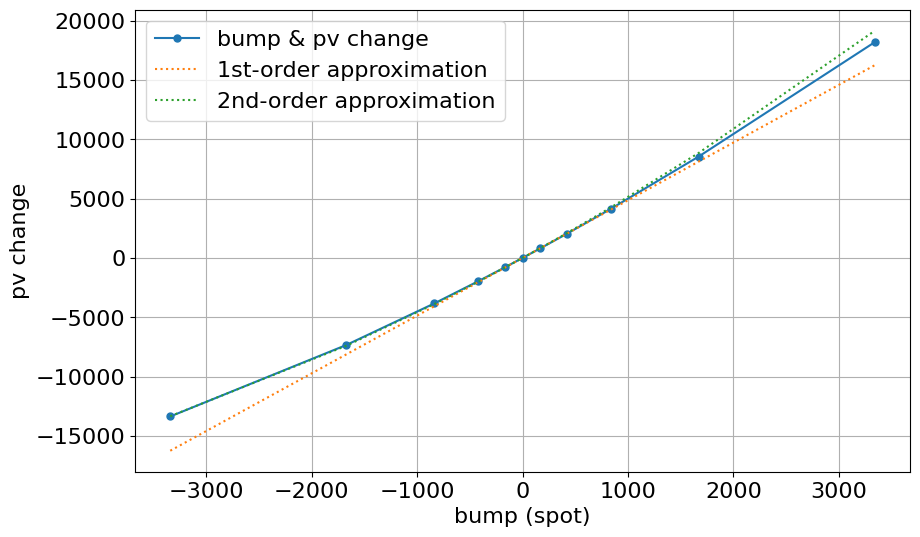

In [18]:
plot_bumped_pv(res_table, the_replica_optval.qty, spot_bumps, 'spot', 'delta', 'gamma')

### Vol Bumps

In [19]:
# vol bmps 
bumps_in_perc = [-20.0, -10.0, -5.0, -2.5, -1.0, 0.0, +1.0, +2.5, +5.0, +10.0, +20.0]
# market data bump
vol_bumps = {f'{sb}':sb/100 for sb in bumps_in_perc}

# pick the base option to bump
base_optval = the_replica_optval.copy()

# dictionary of option valuations with market data bumped
vol_bumps_optvals = {'base': base_optval}
for sb_key, sb_val in vol_bumps.items():
    vol_bumps_optvals[f'vol_bump_{sb_key}%'] = apply_option_valuation_overrides(base_optval, vol_override=sb_val)

# show option valuations
convert_object_dict_to_df(vol_bumps_optvals)

,base,vol_bump_-20.0%,vol_bump_-10.0%,vol_bump_-5.0%,vol_bump_-2.5%,vol_bump_-1.0%,vol_bump_0.0%,vol_bump_1.0%,vol_bump_2.5%,vol_bump_5.0%,vol_bump_10.0%,vol_bump_20.0%
option_valuation_id,9f75c3fc-48d8-4f22-b095-08024f580dd0,fbda13e6-aee4-4535-a26f-97f762d42d9a,7a1c6b8e-386d-4b27-afcc-e98ac64cad93,e9c9b814-cea0-4cfb-a7ce-35a07cdea1d9,cd6798f5-8880-4e54-b01f-df3425680e1d,2efa16c1-c6e4-42c1-b116-2a0f18deec17,a97417b5-46b4-48c1-93a9-f3fa1b6b6e12,83cff803-5836-499d-9c1a-d6517d842c33,e7152068-2c73-41c8-bba5-32d2f50fe740,bbad743a-40fe-4a34-8dc4-bf22aa772dbf,707c9c65-a263-468e-85e8-a5b65d023140,fe161ddb-ab62-46ad-b8d2-0bfdd6c7d570
qty,10,10,10,10,10,10,10,10,10,10,10,10
option_asset_id,None,None,None,None,None,None,None,None,None,None,None,None
underlier_asset_id,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89
strike,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0,20000.0
expiry,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00,2023-09-29 08:00:00
option_type,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL
option_style,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN
contract_size,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
implied_vol_override,None,replacement=None additive_bump=-0.2,replacement=None additive_bump=-0.1,replacement=None additive_bump=-0.05,replacement=None additive_bump=-0.025,replacement=None additive_bump=-0.01,replacement=None additive_bump=0.0,replacement=None additive_bump=0.01,replacement=None additive_bump=0.025,replacement=None additive_bump=0.05,replacement=None additive_bump=0.1,replacement=None additive_bump=0.2


In [20]:
# Run 'compute_option_valuations'
res_table = run_compute_option_valuations(api, vol_bumps_optvals)
res_table

,base,vol_bump_-20.0%,vol_bump_-10.0%,vol_bump_-5.0%,vol_bump_-2.5%,vol_bump_-1.0%,vol_bump_0.0%,vol_bump_1.0%,vol_bump_2.5%,vol_bump_5.0%,vol_bump_10.0%,vol_bump_20.0%
option_valuation_id,9f75c3fc-48d8-4f22-b095-08024f580dd0,fbda13e6-aee4-4535-a26f-97f762d42d9a,7a1c6b8e-386d-4b27-afcc-e98ac64cad93,e9c9b814-cea0-4cfb-a7ce-35a07cdea1d9,cd6798f5-8880-4e54-b01f-df3425680e1d,2efa16c1-c6e4-42c1-b116-2a0f18deec17,a97417b5-46b4-48c1-93a9-f3fa1b6b6e12,83cff803-5836-499d-9c1a-d6517d842c33,e7152068-2c73-41c8-bba5-32d2f50fe740,bbad743a-40fe-4a34-8dc4-bf22aa772dbf,707c9c65-a263-468e-85e8-a5b65d023140,fe161ddb-ab62-46ad-b8d2-0bfdd6c7d570
vol_model,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI
pv,25057.585989,13657.987834,19297.326518,22168.637199,23611.502504,24478.833615,25057.585989,25636.691185,26505.882879,27955.507103,30855.673198,36642.237376
iv,0.632399,0.432399,0.532399,0.582399,0.607399,0.622399,0.632399,0.642399,0.657399,0.682399,0.732399,0.832399
spot_notional,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611,167010.664611
spot_price,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461
forward_price,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649,16616.82649
projection_rate,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707,-0.006707
discounting_rate,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027,-0.01027
delta,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149,0.486149


Let's plot. The PnL profile should be well approximated by the first-order Taylor approximation, i.e. 

vega(base case) * (vol bump).

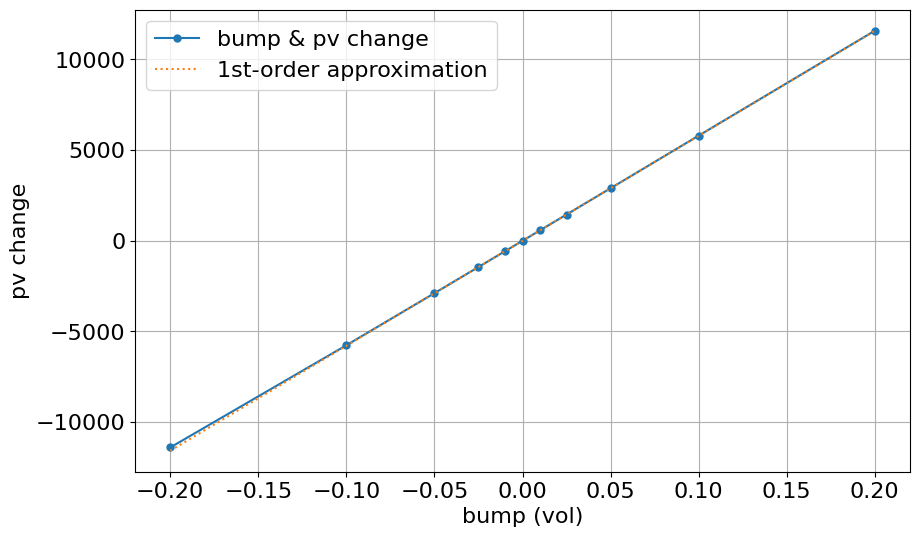

In [21]:
plot_bumped_pv(res_table, the_replica_optval.qty, vol_bumps, 'vol', 'vega')

## Replacements

In [22]:
spot_replacement = spot_base * 1.2
vol_replacement = vol_base * 1.3

my_optval = apply_option_valuation_overrides(the_replica_optval, 
    spot_override=spot_replacement, 
    spot_is_bump=False, 
    vol_override=vol_replacement,
    vol_is_bump=False)
replacement_optvals = {'base': the_replica_optval, 'replacement': my_optval}
convert_object_dict_to_df(replacement_optvals)

,base,replacement
option_valuation_id,9f75c3fc-48d8-4f22-b095-08024f580dd0,2f68c616-1312-4412-bf63-a9d6b6ad7e12
qty,10,10
option_asset_id,None,None
underlier_asset_id,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89
strike,20000.0,20000.0
expiry,2023-09-29 08:00:00,2023-09-29 08:00:00
option_type,OptionType.CALL,OptionType.CALL
option_style,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN
contract_size,1.0,1.0
implied_vol_override,None,replacement=0.82211871805323 additive_bump=None


In [23]:
# Run 'compute_option_valuations'
res_table = run_compute_option_valuations(api, replacement_optvals)
print('Expected Result: spot_price and iv are replaced as specified.')
res_table

Expected Result: spot_price and iv are replaced as specified.


,base,replacement
option_valuation_id,9f75c3fc-48d8-4f22-b095-08024f580dd0,2f68c616-1312-4412-bf63-a9d6b6ad7e12
vol_model,VolModel.SVI,VolModel.SVI
pv,25057.585989,55818.883045
iv,0.632399,0.822119
spot_notional,167010.664611,200412.797533
spot_price,16701.066461,20041.279753
forward_price,16616.82649,16616.82649
projection_rate,-0.006707,-0.248528
discounting_rate,-0.01027,-0.01027
delta,0.486149,0.661663


## Options over Expiries

So far, we considered an option with a specific expiry datetime and a strike. Now, let's consider 'ATM' options over a set of expiries. Here, ATM in the sense that the strike is the same to the spot price. 

In [24]:
# Expiries
expiry_times = {d:datetime.utcnow() + timedelta(d) for d in [7, 14, 30, 60, 90, 180, 360, 720]} # in days

base_optval = the_replica_optval.copy()
expiries_optvals = {}
for d, ex in expiry_times.items():
    expiries_optvals[f"{d}-days"] = apply_option_valuation_overrides(base_optval, strike_override=spot_base, expiry_override=ex)

# show option valuations
convert_object_dict_to_df(expiries_optvals)


,7-days,14-days,30-days,60-days,90-days,180-days,360-days,720-days
option_valuation_id,78bfd0f5-59ed-400e-a5e5-9a12fa3db43a,e81b892a-3173-43f1-b8b2-6595008fe0f6,3b2df15f-a9c0-4be9-926a-94b8b9a97cd6,cbe2edc3-d18f-41a5-a86b-0937203ad756,762aacd6-4ee0-4a9e-a696-39ad124a2a96,1e1cd390-0124-468f-9551-3bcafc038962,609b634f-39e3-4aa4-bc9e-a208a57aee14,e57aa2ed-d0fa-4805-997f-5716c9bae49a
qty,10,10,10,10,10,10,10,10
option_asset_id,None,None,None,None,None,None,None,None
underlier_asset_id,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89,78e2e8e2-419d-4515-9b6a-3d5ff1448e89
strike,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461,16701.066461
expiry,2023-01-03 23:22:00.482650,2023-01-10 23:22:00.482657,2023-01-26 23:22:00.482658,2023-02-25 23:22:00.482659,2023-03-27 23:22:00.482660,2023-06-25 23:22:00.482661,2023-12-22 23:22:00.482662,2024-12-16 23:22:00.482663
option_type,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL,OptionType.CALL
option_style,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN,OptionStyle.EUROPEAN
contract_size,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
implied_vol_override,None,None,None,None,None,None,None,None


In [25]:
# Run 'compute_option_valuations'
res_table = run_compute_option_valuations(api, expiries_optvals)
res_table

,7-days,14-days,30-days,60-days,90-days,180-days,360-days,720-days
option_valuation_id,78bfd0f5-59ed-400e-a5e5-9a12fa3db43a,e81b892a-3173-43f1-b8b2-6595008fe0f6,3b2df15f-a9c0-4be9-926a-94b8b9a97cd6,cbe2edc3-d18f-41a5-a86b-0937203ad756,762aacd6-4ee0-4a9e-a696-39ad124a2a96,1e1cd390-0124-468f-9551-3bcafc038962,609b634f-39e3-4aa4-bc9e-a208a57aee14,e57aa2ed-d0fa-4805-997f-5716c9bae49a
vol_model,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI,VolModel.SVI
pv,3472.974188,5160.334898,8160.100767,13683.963277,18135.544693,28518.225874,42085.092726,59852.39392
iv,0.386654,0.410653,0.449646,0.525916,0.567103,0.626187,0.646097,0.646097
spot_notional,167015.240019,167015.240019,167015.240019,167015.240019,167015.240019,167015.240019,167015.240019,167015.240019
spot_price,16701.524002,16701.524002,16701.524002,16701.524002,16701.524002,16701.524002,16701.524002,16701.524002
forward_price,16681.076929,16659.716121,16610.891416,16592.457141,16574.135979,16570.579729,16659.815656,16842.661209
projection_rate,-0.063779,-0.065317,-0.066214,-0.039873,-0.031067,-0.01597,-0.002537,0.004269
discounting_rate,-0.063879,-0.065401,-0.066214,-0.039877,-0.031067,-0.01597,-0.007883,-0.003942
delta,0.488437,0.51048,0.509463,0.574335,0.594728,0.622087,0.665908,0.741055


Let's plot some fields from the valuation results over expiries

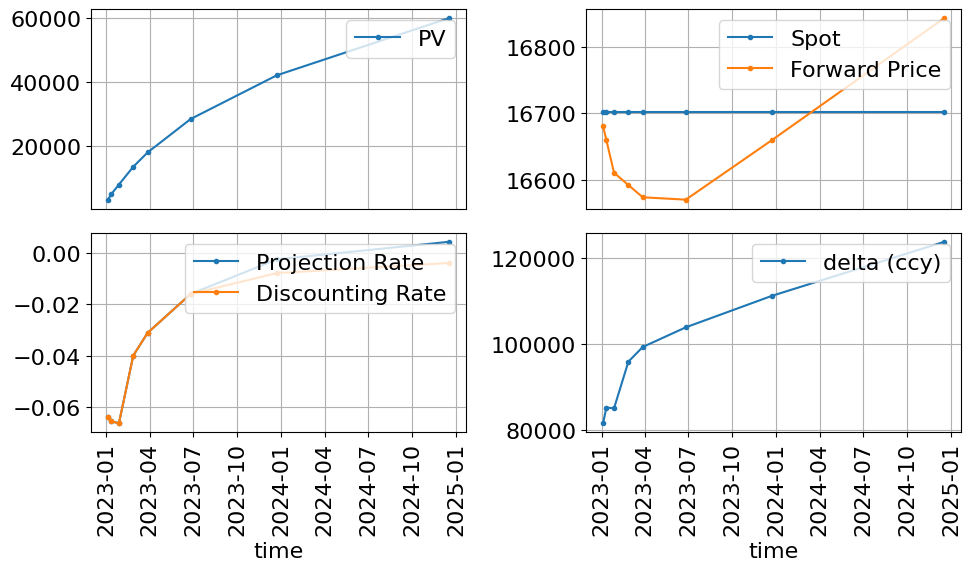

In [26]:
plot_valuation_results(res_table, expiry_times.values())

# END